# Single Pixel Coordinate Prediction

## Problem
Predicting the (x, y) coordinates of a single white pixel in a 50×50 grayscale image.

## Requirements
- Python 3.8+
- PyTorch, NumPy, Matplotlib (pre-installed in Colab)

## Approach
- Generated synthetic dataset with 10k samples
- Tested two models: FCN (baseline, flattened) and CNN (spatial features)
- Evaluated using MSE loss and Euclidean distance

### Imports

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset

### Dataset *Creation*

In [38]:
def single_pixel_dataset(num_samples, image_size):
    pixel_coords = np.random.randint(0, image_size, size=(num_samples,2))
    images = np.zeros((num_samples, image_size, image_size), dtype=np.float32)
    for idx, (x,y) in enumerate(pixel_coords):
        images[idx, y, x] = 1.0

    images_tensor = torch.FloatTensor(images).unsqueeze(1)
    coords_tensor = torch.FloatTensor(pixel_coords)

    return TensorDataset(images_tensor, coords_tensor)

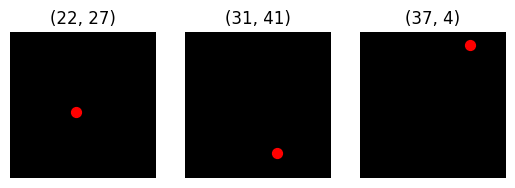

In [39]:
# Dataset choices:
# - 10k samples: suitable for ensuring robustness
# - random pixel positions: improves data representation

dataset = single_pixel_dataset(10000,50)
if len(dataset) == 0:
    raise ValueError("Dataset creation failed")

fig, axes = plt.subplots(1,3)
for i, ax in enumerate(axes):
    img, coords = dataset[i]
    ax.imshow(img.squeeze(), cmap='gray')
    ax.scatter(coords[0], coords[1], c='red', s=50)
    ax.set_title(f"({int(coords[0])}, {int(coords[1])})")
    ax.axis('off')
plt.show()

### Train-Test Split

In [40]:
# standard train,test split
train_size = int(0.8 * len(dataset))
train_set, test_set = random_split(dataset, [train_size, len(dataset) - train_size])
print("train and test set:",len(train_set), len(test_set))
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)
print("train and test loaders:",len(train_loader), len(test_loader))

train and test set: 8000 2000
train and test loaders: 250 63


###
FCN (fully connected) Model- Simple baseline, flattens image and predicts directly



In [55]:
# Model 1: Fully Connected Network (FCN)
# Trying a simple - flattening and predicting approach
# Using standard hyperparameters

def build_FCN(output_dim1,output_dim2,img_size=50,device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = nn.Sequential(
        nn.Linear(img_size * img_size, output_dim1),
        nn.ReLU(),
        nn.Linear(output_dim1, output_dim2),
        nn.ReLU(),
        nn.Linear(output_dim2, 2)
    ).to(device)

    return model,device

model, device = build_FCN(512,128)
if model is None:
    raise ValueError("Model initialization failed")
print(f"Using device: {device}")

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Using device: cpu


In [56]:
# Training FCN
epochs = 20
for epoch in range(epochs):
    model.train()
    train_loss = 0

    for images, targets in train_loader:
        images = images.view(images.size(0),-1).to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, targets in test_loader:
            images = images.view(images.size(0),-1).to(device)
            targets = targets.to(device)
            outputs = model(images)
            val_loss += criterion(outputs,targets).item()

    val_loss /= len(test_loader)

    print(f"Epoch {epoch+1}/{epochs} - Train: {train_loss:.4f}, Val: {val_loss:.4f}")

Epoch 1/20 - Train: 302.9302, Val: 145.2457
Epoch 2/20 - Train: 117.3893, Val: 107.6645
Epoch 3/20 - Train: 89.5011, Val: 51.4177
Epoch 4/20 - Train: 12.0430, Val: 11.9149
Epoch 5/20 - Train: 1.3569, Val: 10.1743
Epoch 6/20 - Train: 0.8350, Val: 10.1941
Epoch 7/20 - Train: 0.9990, Val: 10.4896
Epoch 8/20 - Train: 1.2081, Val: 10.5062
Epoch 9/20 - Train: 1.3041, Val: 10.6734
Epoch 10/20 - Train: 1.2944, Val: 10.4717
Epoch 11/20 - Train: 1.0809, Val: 10.3555
Epoch 12/20 - Train: 1.0471, Val: 10.3209
Epoch 13/20 - Train: 1.0624, Val: 10.5020
Epoch 14/20 - Train: 1.0956, Val: 10.3534
Epoch 15/20 - Train: 1.0366, Val: 10.3700
Epoch 16/20 - Train: 1.0338, Val: 10.1876
Epoch 17/20 - Train: 0.9639, Val: 10.2537
Epoch 18/20 - Train: 0.8699, Val: 10.1650
Epoch 19/20 - Train: 0.8766, Val: 10.1289
Epoch 20/20 - Train: 0.8373, Val: 10.0929


In [57]:
# Testing FCN predictions
images, coords = next(iter(test_loader))
images = images.view(images.size(0),-1).to(device)
coords = coords.to(device)

model.eval()
with torch.no_grad():
    preds = model(images)

# checking error metrics
mse_loss_fn = nn.MSELoss()
mse_loss = mse_loss_fn(preds, coords).item()

euclidean_dist = torch.sqrt(((preds - coords)**2).sum(dim=1))
mean_distance = euclidean_dist.mean().item()

print("MSE:", round(mse_loss,4))
print("Average Euclidean distance:", round(mean_distance,4))

MSE: 3.0674
Average Euclidean distance: 1.4691


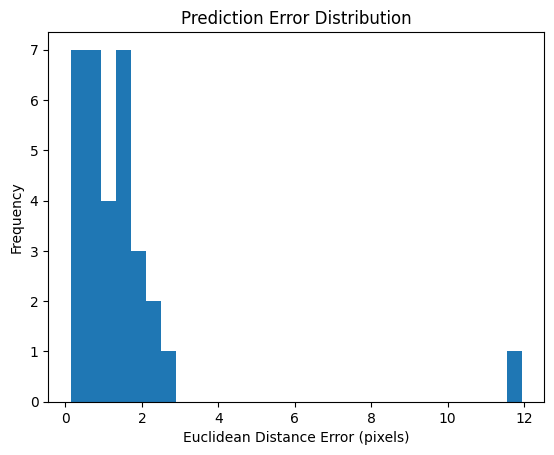

In [58]:
# Error Distribution

errors = torch.sqrt(((preds - coords)**2).sum(dim=1)).cpu().numpy()

plt.hist(errors, bins=30)
plt.xlabel('Euclidean Distance Error (pixels)')
plt.ylabel('Frequency')
plt.title('Prediction Error Distribution')
plt.show()

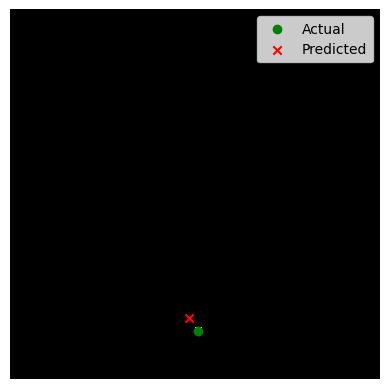

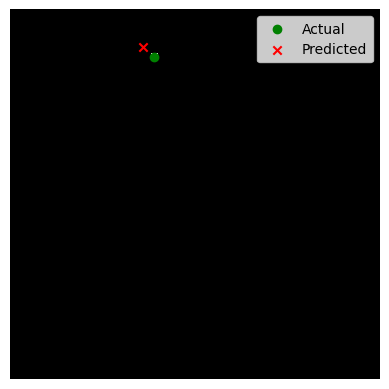

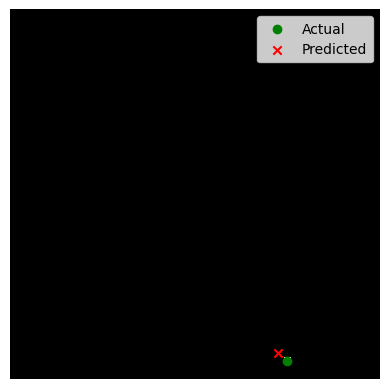

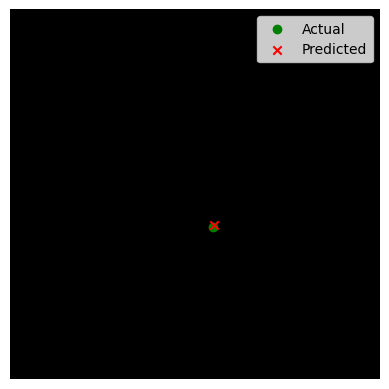

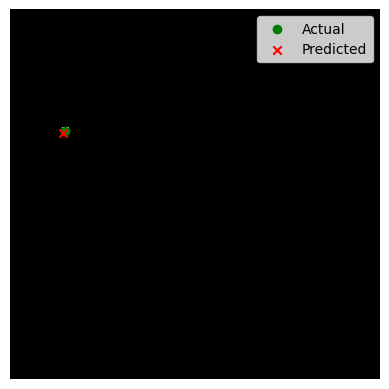

In [44]:
# visualizing predictions vs ground truth pixel
for i in range(5):
    img = images[i].cpu().squeeze()
    img = img.view(50,50)
    actual_x, actual_y = coords[i].cpu().numpy()
    pred_x, pred_y = preds[i].cpu().numpy()

    plt.imshow(img, cmap='gray')
    plt.scatter(actual_x, actual_y, color='green', label='Actual', marker='o')
    plt.scatter(pred_x, pred_y, color='red', label='Predicted', marker='x')
    plt.legend()
    plt.axis('off')
    plt.show()

### CNN (convolutional) Model -  Uses convolution to preserve spatial structure

In [59]:
# Model 2: Convolutional Neural Network (CNN)
# Trying CNN to compare if preserving spatial structure helps vs flattening
# Using standard hyperparameters

def build_small_CNN(img_size, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = nn.Sequential(
        nn.Conv2d(1, 8, 3, padding=1),
        nn.ReLU(),
        nn.Conv2d(8, 16, 3, padding=1),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(16*img_size*img_size, 64),
        nn.ReLU(),
        nn.Linear(64, 2)
    ).to(device)

    return model, device


model, device = build_small_CNN(50)
if model is None:
    raise ValueError("Model initialization failed")
print(f"Using device: {device}")

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Using device: cpu


In [60]:
# Training CNN

epochs = 5

for epoch in range(epochs):
    model.train()
    train_loss = 0

    for images, targets in train_loader:
        if len(images.shape) == 3:
            images = images.unsqueeze(1)
        images = images.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, targets in test_loader:
            if images.ndim == 3:
                images = images.unsqueeze(1)
            images = images.to(device)
            targets = targets.to(device)
            outputs = model(images)
            val_loss += criterion(outputs,targets).item()

    val_loss /= len(test_loader)

    print(f"Epoch {epoch+1}/{epochs} - Train: {train_loss:.4f}, Val: {val_loss:.4f}")

Epoch 1/5 - Train: 169.2027, Val: 10.4617
Epoch 2/5 - Train: 4.2984, Val: 2.6052
Epoch 3/5 - Train: 2.0917, Val: 1.7006
Epoch 4/5 - Train: 1.4989, Val: 1.4492
Epoch 5/5 - Train: 1.1142, Val: 1.3253


In [50]:
# Testing CNN predictions

images, coords = next(iter(test_loader))
images = images.view(images.size(0), 1, 50, 50).to(device)
coords = coords.to(device)

model.eval()
with torch.no_grad():
    preds = model(images)

# Using MSE for loss and euclidean distance for actual pixel errors

mse_loss_fn = nn.MSELoss()
mse_loss = mse_loss_fn(preds, coords).item()

euclidean_dist = torch.sqrt(((preds - coords)**2).sum(dim=1))
mean_distance = euclidean_dist.mean().item()

print("MSE:", round(mse_loss,4))
print("Average Euclidean distance:", round(mean_distance,4))

MSE: 0.3782
Average Euclidean distance: 0.6548


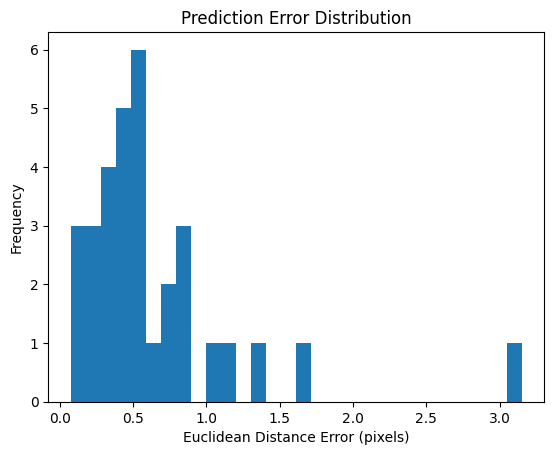

In [51]:
# Error Distribution

errors = torch.sqrt(((preds - coords)**2).sum(dim=1)).cpu().numpy()

plt.hist(errors, bins=30)
plt.xlabel('Euclidean Distance Error (pixels)')
plt.ylabel('Frequency')
plt.title('Prediction Error Distribution')
plt.show()

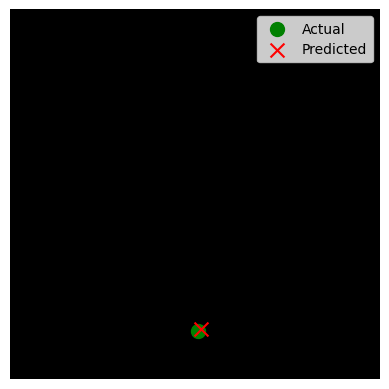

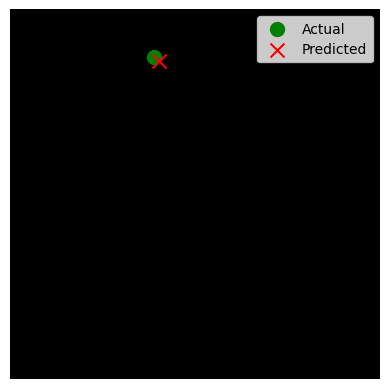

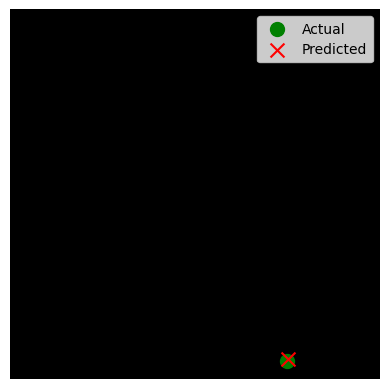

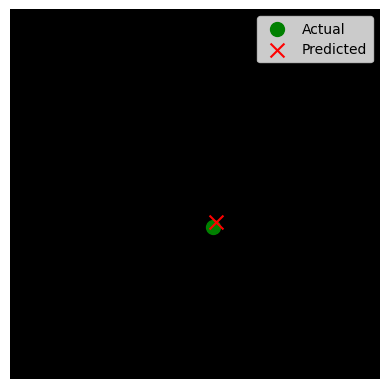

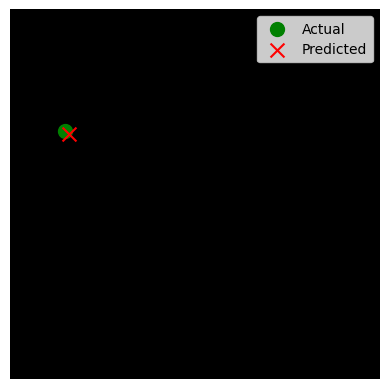

In [48]:
# visualizing CNN predictions

for i in range(5):
    img = images[i].cpu().squeeze()
    gt_x, gt_y = coords[i].cpu().numpy()
    pred_x, pred_y = preds[i].cpu().numpy()

    plt.imshow(img, cmap='gray')
    plt.scatter(gt_x, gt_y, c='green', s=100, label='Actual', marker='o')
    plt.scatter(pred_x, pred_y, c='red', s=100, label='Predicted', marker='x')
    plt.legend()
    plt.axis('off')
    plt.show()


## Results

CNN converged faster along with less prediction MSE in fewer epochs compared to FCN, so the CNN model must be used in production.

MSE: 0.088
Euclidean Distance: 0.42


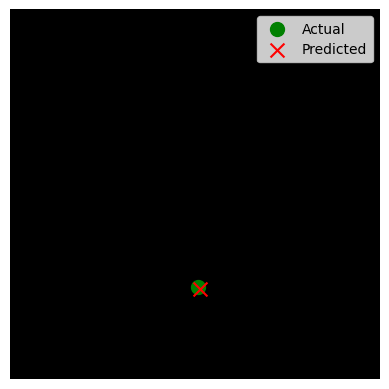

In [49]:
# Testing on a new image

img = np.zeros((50,50), dtype=np.float32)
x1, y1 = np.random.randint(0,50,2)
img[y1, x1] = 1.0


coords = torch.tensor([[x1, y1]], dtype=torch.float32).to(device)
img_tensor = torch.tensor(img, dtype=torch.float32).view(1,1,50,50).to(device)

model.eval()
with torch.no_grad():
    pred1 = model(img_tensor)

mse = nn.MSELoss()(pred1, coords).item()
dist = torch.sqrt(((pred1 - coords)**2).sum()).item()

print("MSE:", round(mse,3))
print("Euclidean Distance:", round(dist,3))

plt.imshow(img, cmap='gray')
plt.scatter(x1, y1, c='green', s=100, label='Actual', marker='o')
plt.scatter(pred1[0,0].cpu(), pred1[0,1].cpu(), c='red', s=100, label='Predicted', marker='x')
plt.legend()
plt.axis('off')
plt.show()